패키지

In [3]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
import os
from tensorflow.keras.applications import (
    ResNet50V2,
)  # 임시로 ResNet50V2로 대체할 수 있음
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


from PIL import Image


# ealry stopping
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# sns.set(font_scale=1.3)

데이터

horse: 1454
human: 1436


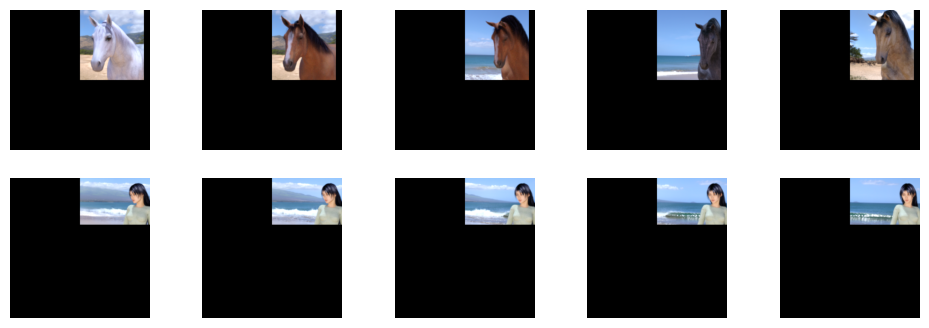

In [5]:
train_horse_dir = "./dataset/train_added/horses"
train_human_dir = "./dataset/train_added/humans"

train_horse_names = os.listdir(train_horse_dir)
train_human_names = os.listdir(train_human_dir)

# 학습 데이터 리스트업
train_horse_names = os.listdir(train_horse_dir)
train_human_names = os.listdir(train_human_dir)

horse_files = [train_horse_dir + "/" + f for f in train_horse_names]
human_files = [train_human_dir + "/" + f for f in train_human_names]

# 학습 데이터의 개수 확인
print("horse:", len(train_horse_names))
print("human:", len(train_human_names))

# 데이터 미리보기
fig, axes = plt.subplots(2, 5, figsize=(12, 4))
ax = np.reshape(axes, -1)

for i, path in enumerate(horse_files[:5] + human_files[:5]):
    img = plt.imread(path)
    ax[i].axis("off")
    ax[i].imshow(img)

plt.show()

In [6]:
base_model = ResNet50V2(
    weights="imagenet", include_top=False, input_shape=(img_size[0], img_size[1], 3)
)

base_model.summary()

NameError: name 'img_size' is not defined

모델설계

In [7]:
# 하이퍼파라미터 설정
img_size = (300, 300)
batch_size = 32
num_classes = 1  # 이진 분류
epochs = 10

# ResNet-34 모델 불러오기 (ImageNet 사전 학습된 가중치 사용)
# Keras에는 ResNet34가 없으므로 대안으로 ResNet50V2를 사용합니다. ResNet34를 직접 구현할 수 있습니다.
base_model = ResNet50V2(
    weights="imagenet", include_top=False, input_shape=(img_size[0], img_size[1], 3)
)

# 모델을 수정하지 않도록 동결
base_model.trainable = False

# 사용자 정의 분류 레이어 추가
model = models.Sequential(
    [
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid"),  # 이진 분류를 위한 출력층
    ]
)

# 모델 요약 출력
model.summary()

# 모델 컴파일
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",  # 이진 분류용 손실 함수
    metrics=["accuracy"],
)

# 데이터 전처리 (ImageDataGenerator 사용)
# train_datagen = ImageDataGenerator(rescale=1./255,  # 정규화
#                                    shear_range=0.2,
#                                    zoom_range=0.2,
#                                    horizontal_flip=True)

train_datagen = ImageDataGenerator(rescale=1.0 / 255, horizontal_flip=True)  # 정규화
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# 훈련 데이터 및 검증 데이터 설정 (경로를 자신의 데이터셋에 맞게 설정하세요)
train_generator = train_datagen.flow_from_directory(
    "./dataset/train_added/",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
)  # 이진 분류

validation_generator = test_datagen.flow_from_directory(
    "./dataset/validation/",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
)  # 이진 분류

# # 콜백 설정
# es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
# checkpoint = ModelCheckpoint(filepath='best_model_resnet34.h5', monitor='val_loss', verbose=1, save_best_only=True)

# 모델 훈련
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 10, 10, 2048)   │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,614,401 (93.90 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Found 2890 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
Epoch 1/10


c:\Users\user\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.9685 - loss: 0.0762 - val_accuracy: 1.0000 - val_loss: 2.0682e-04
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9688 - loss: 0.1750    
Epoch 3/10


c:\Users\user\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


90/90 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.9984 - loss: 0.0082 - val_accuracy: 1.0000 - val_loss: 7.6567e-06
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 596us/step - accuracy: 1.0000 - loss: 0.0019  
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 1.0000 - loss: 6.4089e-04 - val_accuracy: 1.0000 - val_loss: 9.5735e-05
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 563us/step - accuracy: 1.0000 - loss: 9.0367e-05  
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.9999 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 1.6963e-04
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 524us/step - accuracy: 1.0000 - loss: 0.0211
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.9979 - loss: 0.0071 - val_accuracy: 0.9961 - val_loss: 0.0049
Epoch 10/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 568us/step - accuracy: 1.0000 - loss: 4.0884e-06  


In [8]:
# # 모델 저장
# model.save("resnet50_transfer_learning_model2.keras")

In [ ]:
# # 하이퍼파라미터 설정
# img_size = (300, 300)
# batch_size = 128
# num_classes = 1
# epochs = 10

# # ResNet50 모델 불러오기 (ImageNet 사전 학습된 가중치 사용)
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# # 모델을 수정하지 않도록 동결
# base_model.trainable = False

# # 사용자 정의 분류 레이어 추가
# model = models.Sequential([
#     base_model,
#     layers.GlobalAveragePooling2D(),
#     layers.Dense(1024, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(1, activation='sigmoid')  # 이진 분류를 위한 출력층 수정 (softmax -> sigmoid)
# ])

# # 모델 요약 출력
# model.summary()

# # 모델 컴파일
# model.compile(optimizer=Adam(learning_rate=0.001),
#               loss='binary_crossentropy',  # 이진 분류용 binary_crossentropy
#               metrics=['accuracy'])

# # 데이터 전처리 (예: ImageDataGenerator를 사용하여 데이터 증강)
# train_datagen = ImageDataGenerator(rescale=1./255,
#                                    horizontal_flip=True)

# test_datagen = ImageDataGenerator(rescale=1./255)

# # 훈련 데이터 및 검증 데이터 설정 (경로를 자신의 데이터셋에 맞게 설정하세요)
# train_generator = train_datagen.flow_from_directory("./dataset/train_added/",
#                                                     target_size=img_size,
#                                                     batch_size=batch_size,
#                                                     class_mode='binary')  # 이진 분류

# validation_generator = test_datagen.flow_from_directory("./dataset/validation/",
#                                                         target_size=img_size,
#                                                         batch_size=batch_size,
#                                                         class_mode='binary')  # 이진 분류

# # # 끝까지 돌리지 않고 과적합이 일어나기 전 미리 멈추는 기능
# # es = EarlyStopping(
# #     monitor="val_loss", patience=3  # validation loss의 변동에 따라 학습 중지
# # )

# # checkpoint = ModelCheckpoint(
# #     filepath="./checkpoint.keras", verbose=2, save_best_only=True, mode="auto"
# )

# # steps_per_epoch와 validation_steps 설정
# steps_per_epoch = (train_generator.samples // batch_size) + 1
# validation_steps = (validation_generator.samples // batch_size) + 1

# # 모델 훈련
# history = model.fit(train_generator,
#                     steps_per_epoch=steps_per_epoch,
#                     epochs=epochs,
#                     validation_data=validation_generator,
#                     validation_steps=validation_steps,
#                     )#callbacks=[checkpoint, es])

# # # 모델 저장
# # model.save('resnet50_transfer_learning_model.h5')

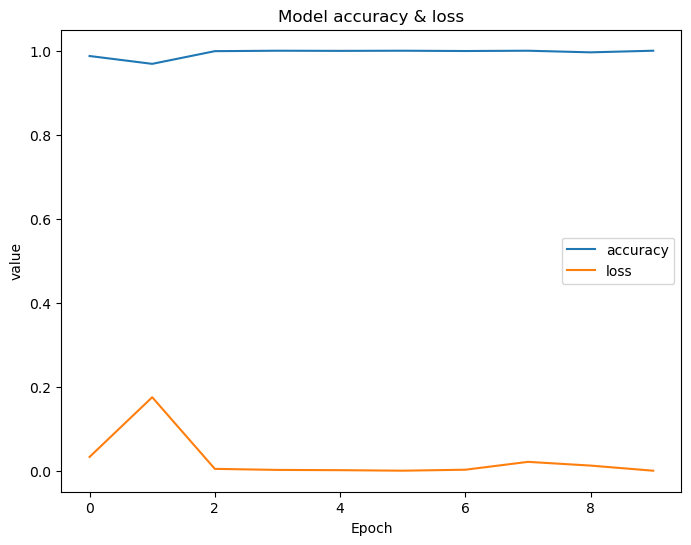

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(history.history["accuracy"])
plt.plot(history.history["loss"])
plt.title("Model accuracy & loss")
plt.xlabel("Epoch")
plt.ylabel("value")
plt.legend(["accuracy", "loss"], loc="center right")
plt.show()

In [14]:
# 모델 검증
results = model.evaluate(validation_generator)
print("test loss, test acc:", results)

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 935ms/step - accuracy: 0.9965 - loss: 0.0045
test loss, test acc: [0.0051779113709926605, 0.99609375]


In [15]:
# 이미지 전처리
dlist = "./dataset/test/"
predict_list = os.listdir(dlist)
print(predict_list)

img = [cv2.imread(dlist + i) for i in predict_list]
img = [cv2.resize(i, (300, 300)) for i in img]
img = np.array(img)
img = img.astype("float32") / 255.0

# 분류
cutoff = 0.5
predictions = model.predict(img)
print(predictions >= cutoff)

['horse (1).jpg', 'horse (1).png', 'horse (10).jpg', 'horse (11).jpg', 'horse (12).jpg', 'horse (13).jpg', 'horse (14).jpg', 'horse (15).jpg', 'horse (16).jpg', 'horse (17).jpg', 'horse (18).jpg', 'horse (19).jpg', 'horse (2).jpg', 'horse (2).png', 'horse (20).jpg', 'horse (21).jpg', 'horse (22).jpg', 'horse (23).jpg', 'horse (24).jpg', 'horse (25).jpg', 'horse (26).jpg', 'horse (27).jpg', 'horse (28).jpg', 'horse (29).jpg', 'horse (3).jpg', 'horse (3).png', 'horse (30).jpg', 'horse (31).jpg', 'horse (32).jpg', 'horse (33).jpg', 'horse (34).jpg', 'horse (35).jpg', 'horse (36).jpg', 'horse (37).jpg', 'horse (38).jpg', 'horse (39).jpg', 'horse (4).jpg', 'horse (4).png', 'horse (40).jpg', 'horse (41).jpg', 'horse (42).jpg', 'horse (43).jpg', 'horse (44).jpg', 'horse (45).jpg', 'horse (46).jpg', 'horse (47).jpg', 'horse (48).jpg', 'horse (49).jpg', 'horse (5).jpg', 'horse (50).jpg', 'horse (51).jpg', 'horse (52).jpg', 'horse (53).jpg', 'horse (54).jpg', 'horse (55).jpg', 'horse (56).jpg', 

In [16]:
predictions

array([[6.78714691e-03],
       [8.79363865e-02],
       [1.77311897e-02],
       [1.77311897e-02],
       [1.17183966e-03],
       [3.27507905e-08],
       [8.17551685e-04],
       [2.39733094e-10],
       [8.45635714e-11],
       [9.99851704e-01],
       [1.71914882e-09],
       [1.90817772e-07],
       [2.60698885e-09],
       [2.36954435e-07],
       [3.23246168e-05],
       [2.72495208e-06],
       [1.74187541e-01],
       [3.17995000e-06],
       [4.99585973e-09],
       [2.63942166e-08],
       [9.24255437e-05],
       [1.18119940e-08],
       [3.78160871e-06],
       [2.28662287e-07],
       [4.80555471e-08],
       [9.99966085e-01],
       [1.13029175e-09],
       [2.00571426e-09],
       [5.49544723e-07],
       [2.19263043e-03],
       [2.51862975e-09],
       [2.92307144e-04],
       [3.91557523e-06],
       [1.05295760e-06],
       [2.95978243e-05],
       [2.33515180e-04],
       [6.39637801e-06],
       [9.99953926e-01],
       [2.50164044e-06],
       [8.80426087e-05],


In [17]:
array = np.array([0] * 100 + [1] * 100)

# Shuffle the array to mix the zeros and ones


print(array)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


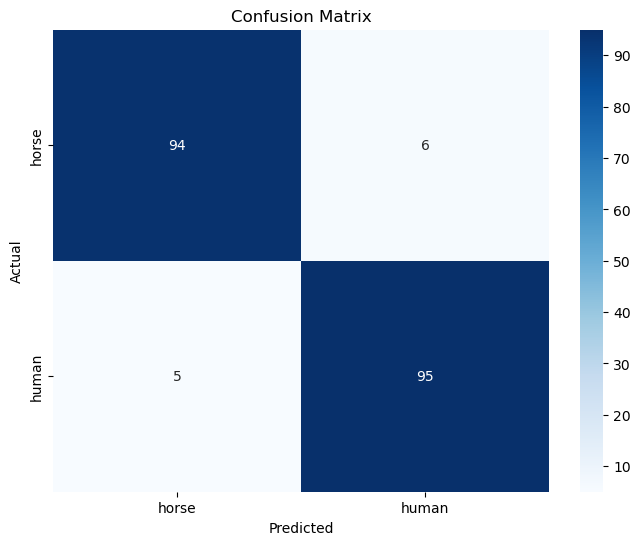

In [18]:
y_true = np.array([0] * 100 + [1] * 100)
y_pred = predictions
y_pred_classes = np.round(y_pred).astype(int).flatten()  # 예측값을 0 또는 1로 변환

# Confusion Matrix 계산
cm = confusion_matrix(y_true, y_pred_classes)

# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["horse", "human"],
    yticklabels=["horse", "human"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()